In [1]:
#!pip install opencv-python

    100% |████████████████████████████████| 15.5MB 78kB/s  eta 0:00:01


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range
import tensorflow as tf

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
import cv2
import glob

#### data processing

In [3]:
# function is to retrieve image id from the file path
def get_image_id(file_path):
    image_id = file_path.split('/')[-1].replace('.jpg','')
    return image_id

In [4]:
# test the above function out
get_image_id('./train/000bec180eb18c7604dcecc8fe0dba07.jpg')

'000bec180eb18c7604dcecc8fe0dba07'

In [4]:
# the function is to load the image files from the local directory
def load_images(path):
    images = []
    gray_images = []
    image_ids = []

    for file in glob.glob(path):
        image_ids.append(get_image_id(file))
        #load image to rgb
        raw_image  = cv2.imread(file)
        #resize
        resized_image = cv2.resize(raw_image, (224, 224)) 
        #rgb to gray
        #grayimage = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        #gray_images.append(grayimage)
        images.append(resized_image)
    # we got list here, but return array for easy manipulation later
    return np.array(images), np.array(image_ids) #np.array(gray_images),

In [5]:
train_images, train_image_ids = load_images('./train/*.jpg')

In [6]:
test_images,test_image_ids = load_images('./test/*.jpg')

In [8]:
def display_img(single_img):
    bgr_img = single_img
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)

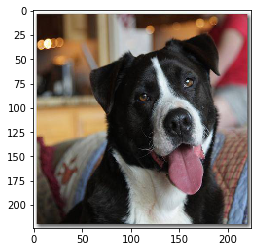

In [9]:
display_img(train_images[0])

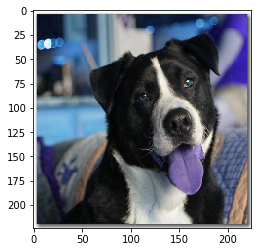

In [10]:
plt.imshow(train_images[0] )

In [7]:
print('train  image shape is {}'.format(train_images.shape))
#print('test image shape is {}'.format(test_images.shape))
#print('train gray image shape is {}'.format(train_gray_images.shape))
#print('test gray image shape is {}'.format(test_gray_images.shape))

train  image shape is (10222, 224, 224, 3)


In [8]:
train_raw_labels = pd.read_csv("labels.csv")
train_raw_labels.shape

(10222, 2)

In [9]:
# since we are not sure if labels.csv is matching to our image list here
# use the train_image_ids and train_raw_labels to get the train_labels
image_id_df = pd.DataFrame(train_image_ids, columns=['id'])
image_id_df.head(4)

,id
0,377c941b6884717dfb825cfe1a11856a
1,36b5e85c07a980914b311163b9f87404
2,98b6235a39ffbd772524aae2c4e1b3ab
3,11bbd6229f14cc68bd0f157a9ef1d47d


In [10]:
print(train_raw_labels.head(4))
print(image_id_df.head(4))
image_labels_df = pd.merge(image_id_df,train_raw_labels, on='id')
print(image_labels_df.head(4))

                                 id        breed
0  000bec180eb18c7604dcecc8fe0dba07  boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97        dingo
2  001cdf01b096e06d78e9e5112d419397     pekinese
3  00214f311d5d2247d5dfe4fe24b2303d     bluetick
                                 id
0  377c941b6884717dfb825cfe1a11856a
1  36b5e85c07a980914b311163b9f87404
2  98b6235a39ffbd772524aae2c4e1b3ab
3  11bbd6229f14cc68bd0f157a9ef1d47d
                                 id             breed
0  377c941b6884717dfb825cfe1a11856a     border_collie
1  36b5e85c07a980914b311163b9f87404       appenzeller
2  98b6235a39ffbd772524aae2c4e1b3ab  mexican_hairless
3  11bbd6229f14cc68bd0f157a9ef1d47d           redbone


In [11]:
train_labels_total = pd.DataFrame(image_labels_df['breed'], columns=['breed'])
# then we apply one hot encoder
train_labels_onehot = pd.get_dummies(train_labels_total)
# train_images is list, change to array in order to use shape()
print( 'Train data:{}, Train labels:{}, Train onehot labels: {}'.format(
    np.array(train_images).shape, train_labels_total.shape, train_labels_onehot.shape ))

Train data:(10222, 224, 224, 3), Train labels:(10222, 1), Train onehot labels: (10222, 120)


there are 120 unique species in training data
the frequency distribution of breed in training data is:


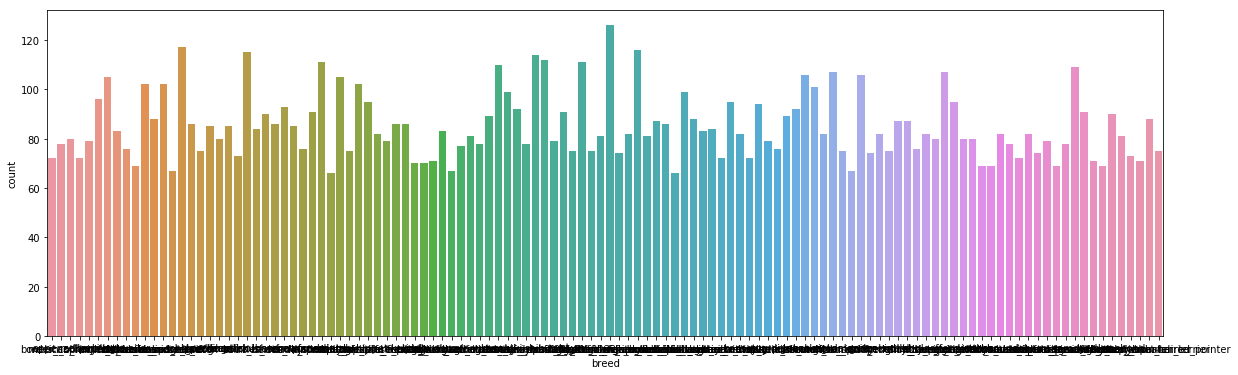

In [12]:
import seaborn as sns
print('there are {} unique species in training data'.format(len(train_labels_total['breed'].unique())))
f, ax = plt.subplots(figsize=(20, 6))
print('the frequency distribution of breed in training data is:')
sns.countplot( x= 'breed',data=image_labels_df);


In [12]:
from sklearn.model_selection import train_test_split

# Take 1/3 images from the training data, and leave the remainder in training
train_data, valid_data, train_labels, valid_labels = train_test_split(train_images, train_labels_onehot, test_size=0.33, random_state=2016)
print('Training data: ', train_data.shape, train_labels.shape)
print('Validation data: ', valid_data.shape, valid_labels.shape)

Training data:  (6848, 224, 224, 3) (6848, 120)
Validation data:  (3374, 224, 224, 3) (3374, 120)


In [14]:
# Create a normalization function that normalizes values between -0.5 and 0.5 and with mean=0
normalize_simple = lambda dataset: ((dataset / 255.0) - 0.5)

train_dataset = normalize_simple(train_data)
test_dataset = normalize_simple(test_images)
valid_dataset = normalize_simple(valid_data)

In [15]:
test_dataset.shape

(10357, 224, 224, 3)

# Apply CNN

In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=1e-4)
    #initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.zeros(shape)
    #initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name)

In [17]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [18]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

normalize_simple = lambda dataset: ((dataset / 255.0) - 0.5)

In [19]:
train_labels = train_labels.values
valid_labels = valid_labels.values
print(type(train_labels))
print(type(valid_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### run_session function

In [103]:
# Session function derived from that of last Section
# Specify the number of epochs, name to give the model and the dropout probability
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def run_session(num_epochs, name, d_prob=0.0):
    
    with tf.Session(config=config, graph=graph) as session:
            tf.global_variables_initializer().run() 
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(train_labels.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_data[offset:(offset + batch_size)]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, drop_prob : d_prob, training: True}
                #feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels,# drop_prob : d_prob, training: True}
                             #tf_test_dataset : test_dataset, drop_prob : d_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 10) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                            batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            feed_dict = {tf_valid_dataset : batch_valid_data, drop_prob : d_prob}
                            predictions = session.run(valid_prediction, feed_dict) 
                            true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))

            #test_preds = pd.DataFrame(test_prediction.eval(feed_dict=feed_dict).ravel(), columns=['ravel_col'])
            #test_preds.to_csv('/tmp/test_results.csv')
            #print("test prediction result is saved in the file")    
            save_path = saver.save(session, "/home/ubuntu/tensorflowmodels_5/" + name +".ckpt")
            print("Model saved in file: %s" % save_path)

### LeNet, AlexNet and ZFnet were tested using 31 epoch in the following parts. Different dropout values were also tested.

### Modified LeNet

In [102]:
height = 224
width = 224
channels = 3
num_labels = 120

valid_batch_size = 256
test_batch_size = 512
batch_size = 256

learning_rate = 1

## ///// Model definition of parameters
conv1_fmaps = 32
conv1_ksize = 5
conv1_stride = 2
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 5
conv2_stride = 2
conv2_pad = "SAME"

num_fcl1 = 1024

reset_graph()

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    tf_test_dataset = tf.placeholder(tf.float32,
                                     shape=(test_batch_size, height, width, channels), name="TestingData")

    drop_prob = tf.placeholder(tf.float32, name="dropout_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Model with dropout
    def model(data):
        #with tf.variable_scope("model") as scope:
            inputs = tf.cast(data,dtype=tf.float32)
            #inputs = tf.cast(data,dtype=tf.float32)
            #inputs = LeCunLCN(data, data.get_shape().as_list())     
            with tf.variable_scope("layer1") as scope:
                # Convolution
                conv_1 = tf.layers.conv2d(inputs=inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                          strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
                # Max pooling
                pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=[2, 2], strides=2)

            with tf.variable_scope("layer2") as scope:
                conv_2 = tf.layers.conv2d(inputs=pool_1, filters=conv2_fmaps, kernel_size=conv2_ksize, 
                                          strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
                pool_2 = tf.layers.max_pooling2d(conv_2, [2, 2], 2)

            with tf.variable_scope("layer3") as scope:
                print(pool_2.get_shape().as_list())
                pool2_flat = tf.reshape(pool_2, [-1, 14 * 14 * conv2_fmaps])
                full_3 = tf.layers.dense(inputs=pool2_flat, units=num_fcl1, activation=tf.nn.relu)
                
            with tf.variable_scope("layer4") as scope:
                dropout = tf.layers.dropout(full_3, rate=drop_prob, training=training)
                full_4 = tf.layers.dense(inputs=dropout, units=num_labels)

            return full_4
        
    # Training computation.
    with tf.variable_scope("model"):   
        logits = model(tf_train_dataset)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labelset))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits, name="training")
    with tf.variable_scope("model", reuse=True):   
        #scope.reuse_variables()
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="Validation")  # no dropout
    with tf.variable_scope("model", reuse=True):   
        #scope.reuse_variables()
        test_prediction = tf.nn.softmax(model(tf_test_dataset), name="Testing")  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

[256, 14, 14, 64]
[256, 14, 14, 64]
[512, 14, 14, 64]


### different dropout rate were tested  
#### num_epochs=31, LeNet_CNN, d_prob=0.2

In [72]:
num_epochs=31
name = "LeNet_CNN"
d_prob=0.2
run_session(num_epochs, name, d_prob)

Initialized

Minibatch loss at epoch 5: 4.656381607055664
Minibatch accuracy: 4.3
Validation accuracy: 1.4

Minibatch loss at epoch 10: 1.7858822345733643
Minibatch accuracy: 59.0
Validation accuracy: 3.0

Minibatch loss at epoch 15: 0.24222376942634583
Minibatch accuracy: 97.3
Validation accuracy: 3.8

Minibatch loss at epoch 20: 0.07891502231359482
Minibatch accuracy: 98.8
Validation accuracy: 3.8

Minibatch loss at epoch 25: 0.10991857945919037
Minibatch accuracy: 97.7
Validation accuracy: 3.8

Minibatch loss at epoch 30: 0.02273803949356079
Minibatch accuracy: 99.6
Validation accuracy: 3.9

test prediction result is saved in the file
Model saved in file: /tmp/tensorflowmodels/LeNet_CNN.ckpt


#### Train accuracy reaches 0.99 after 30 epoch, but validation accuracy is still very low (0.039), indicating model over fitting.

#### num_epochs=31, LeNet_CNN, d_prob=0.5

In [73]:
num_epochs=31
name = "LeNet_CNN_0.5"
d_prob=0.5
run_session(num_epochs, name, 0.5)

Initialized

Minibatch loss at epoch 5: 4.786524772644043
Minibatch accuracy: 0.4
Validation accuracy: 1.0

Minibatch loss at epoch 10: 4.7847514152526855
Minibatch accuracy: 1.6
Validation accuracy: 1.1

Minibatch loss at epoch 15: 4.7374420166015625
Minibatch accuracy: 2.3
Validation accuracy: 1.2

Minibatch loss at epoch 20: 4.714398384094238
Minibatch accuracy: 2.3
Validation accuracy: 1.5

Minibatch loss at epoch 25: 4.682459831237793
Minibatch accuracy: 2.7
Validation accuracy: 1.6

Minibatch loss at epoch 30: 4.597442150115967
Minibatch accuracy: 3.1
Validation accuracy: 1.5

test prediction result is saved in the file
Model saved in file: /tmp/tensorflowmodels/LeNet_CNN_0.5.ckpt


### Observation:

#### Validation accuracy for dropout rate 0.2 is higher than that of 0.5 for our test run of epoch = 31.

### Modified AlexNet

In [79]:
height = 224
width = 224
channels = 3
num_labels = 120

learning_rate = 1

valid_batch_size = 256
test_batch_size = 512
batch_size = 256
#batch_size = 64

## ///// Model definition of parameters
conv1_fmaps = 64
conv1_ksize = [7,7]
conv1_stride = 3
conv1_pad = "SAME"
pool1_ksize = [3,3]
pool1_stride = 2

conv2_fmaps = 128
conv2_ksize = [3,3]
conv2_stride = 1
conv2_pad = "SAME"
pool2_ksize = [3,3]
pool2_stride = 2

conv3_fmaps = 256
conv3_ksize = [3,3]
conv3_stride = 1
conv3_pad = "SAME"
pool3_ksize = [3,3]
pool3_stride = 2

num_fcl1 = 1024
num_fcl2 = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    tf_test_dataset = tf.placeholder(tf.float32,
                                     shape=(test_batch_size, height, width, channels), name="TestingData")
    
    drop_prob = tf.placeholder(tf.float32, name="dropout_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Model with dropout
    def model(data):
        inputs = tf.cast(data,dtype=tf.float32)
        #inputs = tf.cast(data,dtype=tf.float32)
        #inputs = LeCunLCN(data, data.get_shape().as_list())
        with tf.variable_scope("layer1") as scope:
            # Convolution
            conv_1 = tf.layers.conv2d(inputs=inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                      strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
            # Max pooling
            pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=pool1_ksize, strides=pool1_stride)
            # Normalization and dropout
            norm_1 = tf.nn.lrn(pool_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_1 = tf.layers.dropout(norm_1, rate=drop_prob, training=training)

        with tf.variable_scope("layer2") as scope:
            conv_2 = tf.layers.conv2d(inputs=drop_1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                      strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
            pool_2 = tf.layers.max_pooling2d(inputs=conv_2, pool_size=pool2_ksize, strides=pool2_stride)
            norm_2 = tf.nn.lrn(pool_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_2 = tf.layers.dropout(norm_2, rate=drop_prob, training=training)

        with tf.variable_scope("layer3") as scope:
            conv_3 = tf.layers.conv2d(inputs=drop_2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                                      strides=conv3_stride, padding=conv3_pad, activation=tf.nn.relu)
            pool_3 = tf.layers.max_pooling2d(inputs=conv_3, pool_size=pool3_ksize, strides=pool3_stride)
            norm_3 = tf.nn.lrn(pool_3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_3 = tf.layers.dropout(norm_3, rate=drop_prob, training=training)

        with tf.variable_scope("layer4") as scope:
            reshape_flat = tf.reshape(drop_3, [-1, 8*8*conv3_fmaps])
            full_4 = tf.layers.dense(inputs=reshape_flat, units=num_fcl1, activation=tf.nn.relu)

        with tf.variable_scope("layer5") as scope:
            full_5 = tf.layers.dense(inputs=full_4, units=num_fcl2, activation=tf.nn.relu)

        with tf.variable_scope("layer6") as scope:
            full_6 = tf.layers.dense(inputs=full_5, units=num_labels)

        return full_6
    
    # Training computation.
    with tf.variable_scope("model"):   
        logits = model(tf_train_dataset)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labelset))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits, name="training")
    with tf.variable_scope("model", reuse=True):   
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="Validation")  # no dropout
    with tf.variable_scope("model", reuse=True):   
        test_prediction = tf.nn.softmax(model(tf_test_dataset), name="Testing")  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

#### num_epochs=31, AlexNet, d_prob=0.2

In [80]:
num_epochs=31
name = "AlexNet_0.2"
d_prob=0.2
run_session(num_epochs, name, 0.2)

Initialized

Minibatch loss at epoch 5: 4.828603267669678
Minibatch accuracy: 0.0
Validation accuracy: 0.8

Minibatch loss at epoch 10: 4.67575740814209
Minibatch accuracy: 2.3
Validation accuracy: 1.9

Minibatch loss at epoch 15: 4.313046455383301
Minibatch accuracy: 5.9
Validation accuracy: 3.2

Minibatch loss at epoch 20: 3.8381824493408203
Minibatch accuracy: 13.3
Validation accuracy: 5.0

Minibatch loss at epoch 25: 3.9084088802337646
Minibatch accuracy: 12.9
Validation accuracy: 5.3

Minibatch loss at epoch 30: 2.665877342224121
Minibatch accuracy: 37.1
Validation accuracy: 6.7

test prediction result is saved in the file
Model saved in file: /tmp/tensorflowmodels/AlexNet_0.2.ckpt


### ZFNet  simple

#### filter number are smaller than original model to save running time, structure is the same

In [104]:
height = 224
width = 224
channels = 3
num_labels = 120

learning_rate = 1

valid_batch_size = 256
test_batch_size = 109
batch_size = 256
#batch_size = 64

## ///// Model definition of parameters
conv1_fmaps = 96
conv1_ksize = [7,7]
conv1_stride = 2
conv1_pad = "SAME"
pool1_ksize = [3,3]
pool1_stride = 2

conv2_fmaps = 256
conv2_ksize = [5,5]
conv2_stride = 2
conv2_pad = "SAME"
pool2_ksize = [3,3]
pool2_stride = 2

conv3_fmaps = 256
conv3_ksize = [3,3]
conv3_stride = 1
conv3_pad = "SAME"
pool3_ksize = [3,3]
pool3_stride = 2

num_fcl1 = 1024
num_fcl2 = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    tf_test_dataset = tf.placeholder(tf.float32,
                                     shape=(test_batch_size, height, width, channels), name="TestingData")
    
    drop_prob = tf.placeholder(tf.float32, name="dropout_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Model with dropout
    def model(data):
        inputs = tf.cast(data,dtype=tf.float32)
        #inputs = tf.cast(data,dtype=tf.float32)
        #inputs = LeCunLCN(data, data.get_shape().as_list())
        with tf.variable_scope("layer1") as scope:
            # Convolution
            conv_1 = tf.layers.conv2d(inputs=inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                      strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
            # Max pooling
            pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=pool1_ksize, strides=pool1_stride)
            # Normalization and dropout
            norm_1 = tf.nn.lrn(pool_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_1 = tf.layers.dropout(norm_1, rate=drop_prob, training=training)

        with tf.variable_scope("layer2") as scope:
            conv_2 = tf.layers.conv2d(inputs=drop_1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                      strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
            pool_2 = tf.layers.max_pooling2d(inputs=conv_2, pool_size=pool2_ksize, strides=pool2_stride)
            norm_2 = tf.nn.lrn(pool_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_2 = tf.layers.dropout(norm_2, rate=drop_prob, training=training)

        with tf.variable_scope("layer3") as scope:
            conv_3 = tf.layers.conv2d(inputs=drop_2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                                      strides=conv3_stride, padding=conv3_pad, activation=tf.nn.relu)
            pool_3 = tf.layers.max_pooling2d(inputs=conv_3, pool_size=pool3_ksize, strides=pool3_stride)
            norm_3 = tf.nn.lrn(pool_3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_3 = tf.layers.dropout(norm_3, rate=drop_prob, training=training)

        with tf.variable_scope("layer4") as scope:
            reshape_flat = tf.reshape(drop_3, [-1, 6*6*conv3_fmaps])
            full_4 = tf.layers.dense(inputs=reshape_flat, units=num_fcl1, activation=tf.nn.relu)

        with tf.variable_scope("layer5") as scope:
            full_5 = tf.layers.dense(inputs=full_4, units=num_fcl2, activation=tf.nn.relu)

        with tf.variable_scope("layer6") as scope:
            full_6 = tf.layers.dense(inputs=full_5, units=num_labels)

        return full_6
    
    # Training computation.
    with tf.variable_scope("model"):   
        logits = model(tf_train_dataset)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labelset))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits, name="training")
    with tf.variable_scope("model", reuse=True):   
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="Validation")  # no dropout
    with tf.variable_scope("model", reuse=True):   
        test_prediction = tf.nn.softmax(model(tf_test_dataset), name="Testing")  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

In [83]:
run_session(31, "ZFNet_0.2", 0.2)

Initialized

Minibatch loss at epoch 5: 4.81194543838501
Minibatch accuracy: 0.8
Validation accuracy: 1.2

Minibatch loss at epoch 10: 4.672250747680664
Minibatch accuracy: 1.6
Validation accuracy: 2.2

Minibatch loss at epoch 15: 4.305853366851807
Minibatch accuracy: 6.2
Validation accuracy: 3.9

Minibatch loss at epoch 20: 3.8438432216644287
Minibatch accuracy: 12.1
Validation accuracy: 5.8

Minibatch loss at epoch 25: 4.061464309692383
Minibatch accuracy: 10.2
Validation accuracy: 6.0

Minibatch loss at epoch 30: 3.1192610263824463
Minibatch accuracy: 29.3
Validation accuracy: 7.4

test prediction result is saved in the file
Model saved in file: /tmp/tensorflowmodels/ZFNet_0.2.ckpt


### ZFNet full

#### exactly same as  original model.

In [88]:
height = 224
width = 224
channels = 3
num_labels = 120

learning_rate = 0.1

valid_batch_size = 256
test_batch_size = 512
batch_size = 256
#batch_size = 64

## ///// Model definition of parameters
conv1_fmaps = 96
conv1_ksize = [7,7]
conv1_stride = 2
conv1_pad = "SAME"
pool1_ksize = [3,3]
pool1_stride = 2

conv2_fmaps = 256
conv2_ksize = [5,5]
conv2_stride = 2
conv2_pad = "SAME"
pool2_ksize = [3,3]
pool2_stride = 2

conv3_fmaps = 384
conv3_ksize = [3,3]
conv3_stride = 1
conv3_pad = "SAME"

conv4_fmaps = 384
conv4_ksize = [3,3]
conv4_stride = 1
conv4_pad = "SAME"

conv5_fmaps = 256
conv5_ksize = [3,3]
conv5_stride = 1
conv5_pad = "SAME"
pool5_ksize = [3,3]
pool5_stride = 2


num_fcl1 = 4096
num_fcl2 = 4096

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, 
                                      shape=(batch_size, height, width, channels), name="TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, 
                                     shape=(batch_size, num_labels), name="TrainingLabels")
    tf_valid_dataset = tf.placeholder(tf.float32,
                                     shape=(valid_batch_size, height, width, channels), name="ValidationData")
    tf_test_dataset = tf.placeholder(tf.float32,
                                     shape=(test_batch_size, height, width, channels), name="TestingData")
    
    drop_prob = tf.placeholder(tf.float32, name="dropout_prob")
    training = tf.placeholder_with_default(False, shape=[], name='training')

    # Model with dropout
    def model(data):
        inputs = tf.cast(data,dtype=tf.float32)
        #inputs = tf.cast(data,dtype=tf.float32)
        #inputs = LeCunLCN(data, data.get_shape().as_list())
        with tf.variable_scope("layer1") as scope:
            # Convolution
            conv_1 = tf.layers.conv2d(inputs=inputs, filters=conv1_fmaps, kernel_size=conv1_ksize,
                                      strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu)
            # Max pooling
            pool_1 = tf.layers.max_pooling2d(inputs=conv_1, pool_size=pool1_ksize, strides=pool1_stride)
            # Normalization and dropout
            norm_1 = tf.nn.lrn(pool_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_1 = tf.layers.dropout(norm_1, rate=drop_prob, training=training)

        with tf.variable_scope("layer2") as scope:
            conv_2 = tf.layers.conv2d(inputs=drop_1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                      strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu)
            pool_2 = tf.layers.max_pooling2d(inputs=conv_2, pool_size=pool2_ksize, strides=pool2_stride)
            norm_2 = tf.nn.lrn(pool_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_2 = tf.layers.dropout(norm_2, rate=drop_prob, training=training)
            
        with tf.variable_scope("layer3") as scope:    
            conv_3 = tf.layers.conv2d(inputs=drop_2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                                      strides=conv3_stride, padding=conv3_pad, activation=tf.nn.relu)
            norm_3 = tf.nn.lrn(conv_3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_3 = tf.layers.dropout(norm_3, rate=drop_prob, training=training)
            
        with tf.variable_scope("layer4") as scope:    
            conv_4 = tf.layers.conv2d(inputs=drop_3, filters=conv4_fmaps, kernel_size=conv4_ksize,
                                      strides=conv4_stride, padding=conv4_pad, activation=tf.nn.relu)
            norm_4 = tf.nn.lrn(conv_4, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_4 = tf.layers.dropout(norm_4, rate=drop_prob, training=training)
            
        with tf.variable_scope("layer5") as scope:
            conv_5 = tf.layers.conv2d(inputs=drop_4, filters=conv5_fmaps, kernel_size=conv5_ksize,
                                      strides=conv5_stride, padding=conv5_pad, activation=tf.nn.relu)
            pool_5 = tf.layers.max_pooling2d(inputs=conv_5, pool_size=pool5_ksize, strides=pool5_stride)
            norm_5 = tf.nn.lrn(pool_5, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
            drop_5 = tf.layers.dropout(norm_5, rate=drop_prob, training=training)
    
        with tf.variable_scope("layer6") as scope:
            reshape_flat = tf.reshape(drop_5, [-1, 6*6*conv5_fmaps])
            full_6 = tf.layers.dense(inputs=reshape_flat, units=num_fcl1, activation=tf.nn.relu)

        with tf.variable_scope("layer7") as scope:
            full_7 = tf.layers.dense(inputs=full_6, units=num_fcl2, activation=tf.nn.relu)

        with tf.variable_scope("layer8") as scope:
            full_8 = tf.layers.dense(inputs=full_7, units=num_labels)

        return full_8
    
    # Training computation.
    with tf.variable_scope("model"):   
        logits = model(tf_train_dataset)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labelset))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits, name="training")
    with tf.variable_scope("model", reuse=True):   
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset), name="Validation")  # no dropout
    with tf.variable_scope("model", reuse=True):   
        test_prediction = tf.nn.softmax(model(tf_test_dataset), name="Testing")  # no dropout
    saver = tf.train.Saver()   # a saver variable to save the model

In [85]:
run_session(31, "ZFNet_full_0.2", 0.2)

Initialized

Minibatch loss at epoch 5: 4.792494773864746
Minibatch accuracy: 1.6
Validation accuracy: 1.0

Minibatch loss at epoch 10: 4.715511322021484
Minibatch accuracy: 1.6
Validation accuracy: 1.5

Minibatch loss at epoch 15: 4.2796149253845215
Minibatch accuracy: 7.8
Validation accuracy: 4.4

Minibatch loss at epoch 20: 3.4065651893615723
Minibatch accuracy: 22.3
Validation accuracy: 6.2

Minibatch loss at epoch 25: 3.73108172416687
Minibatch accuracy: 19.1
Validation accuracy: 7.0

Minibatch loss at epoch 30: 1.4668047428131104
Minibatch accuracy: 62.5
Validation accuracy: 6.9

test prediction result is saved in the file
Model saved in file: /tmp/tensorflowmodels/ZFNet_full_0.2.ckpt


In [ ]:
run_session(80, "ZFNet_NN", 0.5)

Initialized

Minibatch loss at epoch 20: 2.943589687347412
Minibatch accuracy: 27.7
Validation accuracy: 5.1

Minibatch loss at epoch 40: 0.09762397408485413
Minibatch accuracy: 96.1
Validation accuracy: 5.5

Minibatch loss at epoch 60: 0.0050348201766610146
Minibatch accuracy: 100.0
Validation accuracy: 6.3

Minibatch loss at epoch 80: 0.016209404915571213
Minibatch accuracy: 99.2
Validation accuracy: 6.4



### which model we want to use?

#### For all models we have tested, ZFNet simple, ZFNet full and modified AlexNet have similar validation accuracy after 30 epochs. As ZFNet simple has lowest train accuracy after 30 epoch, we dicided to used this model for further exploration to avoid overfitting

####  ZFNet simple with 60 epoch and dropout rate = 0.5

In [35]:
run_session(60, "ZFNet_0.5_final", 0.5)

Initialized

Minibatch loss at epoch 5: 4.820178508758545
Minibatch accuracy: 0.0
Validation accuracy: 1.0

Minibatch loss at epoch 10: 4.7979607582092285
Minibatch accuracy: 1.2
Validation accuracy: 0.9

Minibatch loss at epoch 15: 4.763845920562744
Minibatch accuracy: 0.8
Validation accuracy: 1.4

Minibatch loss at epoch 20: 4.7376389503479
Minibatch accuracy: 1.2
Validation accuracy: 1.5

Minibatch loss at epoch 25: 4.671397686004639
Minibatch accuracy: 2.3
Validation accuracy: 2.2

Minibatch loss at epoch 30: 4.496409893035889
Minibatch accuracy: 2.3
Validation accuracy: 2.8

Minibatch loss at epoch 35: 4.343696594238281
Minibatch accuracy: 6.2
Validation accuracy: 3.6

Minibatch loss at epoch 40: 4.1155571937561035
Minibatch accuracy: 7.8
Validation accuracy: 4.7

Minibatch loss at epoch 45: 4.185713768005371
Minibatch accuracy: 6.2
Validation accuracy: 6.0

Minibatch loss at epoch 50: 3.8488283157348633
Minibatch accuracy: 11.3
Validation accuracy: 6.6

Minibatch loss at epoch 55

#### ZFNet simple with 100 epoch and dropout rate = 0.2

In [48]:
run_session(100, "ZFNet_0.2_pred", 0.2)

Initialized

Minibatch loss at epoch 5: 4.794414520263672
Minibatch accuracy: 2.0
Validation accuracy: 1.0

Minibatch loss at epoch 10: 4.410125732421875
Minibatch accuracy: 4.7
Validation accuracy: 2.8

Minibatch loss at epoch 15: 3.9177985191345215
Minibatch accuracy: 10.9
Validation accuracy: 5.2

Minibatch loss at epoch 20: 3.371920108795166
Minibatch accuracy: 18.0
Validation accuracy: 7.3

Minibatch loss at epoch 25: 3.599947929382324
Minibatch accuracy: 21.9
Validation accuracy: 8.3

Minibatch loss at epoch 30: 1.7146892547607422
Minibatch accuracy: 57.4
Validation accuracy: 7.7

Minibatch loss at epoch 35: 1.0252755880355835
Minibatch accuracy: 71.5
Validation accuracy: 7.2

Minibatch loss at epoch 40: 0.292295902967453
Minibatch accuracy: 92.2
Validation accuracy: 8.9

Minibatch loss at epoch 45: 0.7945495247840881
Minibatch accuracy: 83.6
Validation accuracy: 9.0

Minibatch loss at epoch 50: 0.09257683902978897
Minibatch accuracy: 98.0
Validation accuracy: 9.0

Minibatch loss

#### use above model to predict test dataset 

In [56]:
with tf.Session(graph=graph) as session:
    ckpt = tf.train.get_checkpoint_state('/home/ubuntu/tensorflowmodels_3/')
    saver.restore(session, ckpt.model_checkpoint_path)
    test_pred = np.empty([0,120])
    for batch_num in range(int(test_dataset.shape[0]/test_batch_size)): 
        batch_test_data = test_dataset[batch_num*test_batch_size:(batch_num+1)*test_batch_size]
        #batch_test_labels = test_labels[batch_num*test_batch_size:(batch_num+1)*test_batch_size]
        feed_dict = {tf_test_dataset : batch_test_data, drop_prob : 1.0}
        predictions = session.run(test_prediction, feed_dict)
        test_pred = np.vstack((test_pred, predictions))


INFO:tensorflow:Restoring parameters from /home/ubuntu/tensorflowmodels_3/ZFNet_0.2_pred.ckpt


In [94]:
# fill the 2 leftovers with Equal Probability for each class
fillarray = np.full((1, 120), float(1/120))
test_pred_2 = np.vstack((test_pred, fillarray, fillarray))
results = pd.DataFrame(test_pred_2)

columns =  pd.read_csv('submission_1.csv').columns[1:]

results.index = test_image_ids
results.columns = columns

In [95]:
print(results.shape)
results.head()

(10357, 120)


,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
fd1a7be32f10493735555e62913c0841,0.009080,0.007613,0.008503,0.009754,0.008097,0.008715,0.008685,0.008951,0.008439,0.008161,...,0.009532,0.008950,0.008387,0.007053,0.008528,0.008119,0.008514,0.009508,0.007032,0.008546
5273d42f02b4715cb93845205995ef64,0.008290,0.008432,0.009974,0.008543,0.007809,0.007479,0.008109,0.008186,0.008107,0.009676,...,0.009345,0.008398,0.007089,0.007419,0.008991,0.008943,0.007734,0.008766,0.007814,0.007859
442057a3142f4d75a1023db363e2fb54,0.008666,0.009192,0.009382,0.008308,0.007706,0.007606,0.008337,0.008190,0.007892,0.009436,...,0.009632,0.008455,0.007016,0.006741,0.008732,0.008406,0.007846,0.008293,0.007679,0.008288
fb03302b030afd122e0f4936c158f6c1,0.009779,0.008458,0.008526,0.009055,0.008817,0.008680,0.008056,0.008732,0.008756,0.009004,...,0.010100,0.008804,0.007931,0.008481,0.008435,0.008605,0.007994,0.008981,0.007112,0.009446
511ca6e3539192aa5c8747bb697e0525,0.009745,0.009179,0.008981,0.009201,0.008808,0.009252,0.007713,0.007621,0.009749,0.010134,...,0.008961,0.008964,0.007975,0.006786,0.008445,0.009192,0.007940,0.008269,0.007058,0.008371


In [93]:
results.to_csv('submission_2.csv', index_label = 'id')

#### the submisson score is 4.76769

### another 100 epoch based on  above model

In [100]:
def rerun_session(num_epochs, name, d_prob=0.0):
    with tf.Session(graph=graph) as session:
            ckpt = tf.train.get_checkpoint_state('/home/ubuntu/tensorflowmodels_3/')
            saver.restore(session, ckpt.model_checkpoint_path)
            loss_summary = tf.summary.scalar('Loss', loss)
            learning_rate_summary = tf.summary.scalar('Learning_rate', learning_rate)
            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("/tmp/tensorflowlogs", session.graph)
            print("Initialized\n")
            epoch = 0
            for step in range(int(train_labels.shape[0]/batch_size)*num_epochs):
                #epoch = int(20*train_labels.shape[0]/batch_size)
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_data[offset:(offset + batch_size)]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, drop_prob : d_prob, training: True}
                #feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels,# drop_prob : d_prob, training: True}
                             #tf_test_dataset : test_dataset, drop_prob : d_prob, training: True}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                
                writer.add_summary(loss_summary.eval(feed_dict=feed_dict), epoch)
                writer.add_summary(learning_rate_summary.eval(), epoch)
                if (offset < batch_size):
                    epoch += 1
                    if (epoch % 5) == 0:
                        print("Minibatch loss at epoch {}: {}".format(epoch, l))
                        print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                        true_preds = 0
                        for batch_num in range(int(valid_labels.shape[0]/valid_batch_size)): 
                            batch_valid_data = valid_data[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            batch_valid_labels = valid_labels[batch_num*valid_batch_size:(batch_num+1)*valid_batch_size]
                            feed_dict = {tf_valid_dataset : batch_valid_data, drop_prob : d_prob}
                            predictions = session.run(valid_prediction, feed_dict) 
                            true_preds += np.sum(np.argmax(predictions, 1) == np.argmax(batch_valid_labels, 1))
                        print("Validation accuracy: {:.1f}\n".format(100.0 * true_preds / valid_data.shape[0]))

            #test_preds = pd.DataFrame(test_prediction.eval(feed_dict=feed_dict).ravel(), columns=['ravel_col'])
            #test_preds.to_csv('/tmp/test_results.csv')
            #print("test prediction result is saved in the file")    
            save_path = saver.save(session, "/home/ubuntu/tensorflowmodels_rerun/" + name +".ckpt")
            print("Model saved in file: %s" % save_path)

In [ ]:
# another 100 epoch 
# rerun_session(100, 'ZFNet_plus_100', 0.2)
# running results is not shown here

#### did not see any improvement of validation data accuracy with 100 more epoch

#### As we do not have enough time to run more epochs or other dropout options, the simple ZFNet model with epoch = 100 and dropout rate =0.2 is the best we can get for this homework. Using full model, higher dropout rate and higher epoch numbers may potentially improve prediction accuracy in test dataset. 
